<a href="https://colab.research.google.com/github/cincinnatilibrary/collection-analysis/blob/master/reports/customer_circulation_choropleth_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHPL - Collection Analysis - **Choropleth Mapping**

<img src="https://ilsweb.cincinnatilibrary.org/img/CHPL_Brandmark_Primary.png" alt="CHPL" title="CHPL" width="300"/>

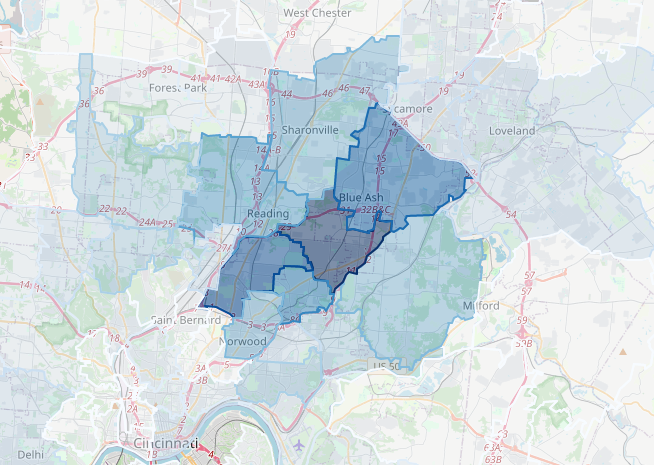

Data sources

* https://ilsaux2.plch.net/
* https://collection-analysis.cincy.pl/

---

1. Click on the `Run cell` button below to get started 

In [1]:
#@title
!pip install -U geopandas folium matplotlib mapclassify > /dev/null
# may need these in the future ...
# !pip install -U altair contextily

# casually download ~500 MB of shape data ... 
!wget --quiet https://www2.census.gov/geo/tiger/TIGER2021/ZCTA520/tl_2021_us_zcta520.zip --output-document=tl_2021_us_zcta520.zip

import geopandas as gpd
import pandas as pd

2. Run something like this query on the Datasette instance: `ilsaux2.plch.net` and download the resulting `.csv` data.

3. Load the data as `.csv` to this colab instance, naming it `current_patrons.csv`

4. Click on the `Run cell button below


In [2]:
#@title
# https://ilsaux2.plch.net/current_patrons?sql=--%0D%0A--+find+counts+of+patrons+with+checkouts+by+branch+in+time+range%0D%0Awith+branch_circs+as+%28%0D%0A++select%0D%0A++++transaction_day%2C%0D%0A++++patron_record_id%2C%0D%0A++++branch_name%0D%0A++from%0D%0A++++circ_trans%0D%0A++where%0D%0A++++%22branch_name%22+%3D+%3Abranch_name%0D%0A++++and+%22op_code%22+%3D+%3Aop_code%0D%0A++++and+%22transaction_day%22+%3E%3D+%3Astart_target_date%0D%0A%29%0D%0Aselect%0D%0A++branch_circs.branch_name%2C%0D%0A++substr%28postal_code%2C+1%2C+5%29+as+postal_code%2C%0D%0A++min%28transaction_day%29%2C%0D%0A++count%28distinct+branch_circs.patron_record_id%29+as+count_patrons%0D%0Afrom%0D%0A++branch_circs%0D%0A++join+patrons+on+patrons.patron_record_id+%3D+branch_circs.patron_record_id%0D%0Agroup+by%0D%0A++1%2C%0D%0A++2%0D%0Ahaving%0D%0A++count_patrons+%3E%3D+1%0D%0A++and+postal_code+is+not+null%0D%0Aorder+by%0D%0A++count_patrons+desc%2C%0D%0A++postal_code+desc&branch_name=Deer+Park&op_code=o&start_target_date=2022-01-01
sql = """\
--
-- find counts of patrons with checkouts by branch in time range
with branch_circs as (
  select
    transaction_day,
    patron_record_id,
    branch_name
  from
    circ_trans
  where
    "branch_name" = :branch_name
    and "op_code" = :op_code
    and "transaction_day" >= :start_target_date
)
select
  branch_circs.branch_name,
  substr(postal_code, 1, 5) as postal_code,
  min(transaction_day),
  count(distinct branch_circs.patron_record_id) as count_patrons
from
  branch_circs
  join patrons on patrons.patron_record_id = branch_circs.patron_record_id
group by
  1,
  2
having
  count_patrons >= 1
  and postal_code is not null
order by
  count_patrons desc,
  postal_code desc
"""

gdf = gpd.read_file('tl_2021_us_zcta520.zip')
# read csv exported from the above query
df = pd.read_csv('/content/current_patrons.csv')
# zips = [str(zip_code) for zip_code in df['postal_code']]

# merge the above dataframe and the dataframe containing our 
# GEOID20
df.rename(columns={"postal_code": "GEOID20"}, inplace=True)
# convert the column to string so we can do our merge
df['GEOID20'] = df['GEOID20'].astype(str)

gdf = gdf.merge(df, on='GEOID20', how='inner')
# gdf.head()

gdf[
    gdf['GEOID20'].isin(
      [str(zip_code) for zip_code in df['GEOID20']]
    )
].explore(
    tiles="OpenStreetMap",
    # tiles="Stamen Toner",
    column="count_patrons",
    scheme="naturalbreaks",
    cmap="Blues",
    # tooltip="count_patrons",
    popup=True,
    k=10 # Number of classes (default 5) 
)

### Note

if you wish to add another map, duplicate this cell, upload a new copy of `current_patrons.csv` and run the newly duplicated cell (like, the example below). 

In [5]:
#@title
# https://ilsaux2.plch.net/current_patrons?sql=--%0D%0A--+find+counts+of+patrons+with+checkouts+by+branch+in+time+range%0D%0Awith+branch_circs+as+%28%0D%0A++select%0D%0A++++transaction_day%2C%0D%0A++++patron_record_id%2C%0D%0A++++branch_name%0D%0A++from%0D%0A++++circ_trans%0D%0A++where%0D%0A++++%22branch_name%22+%3D+%3Abranch_name%0D%0A++++and+%22op_code%22+%3D+%3Aop_code%0D%0A++++and+%22transaction_day%22+%3E%3D+%3Astart_target_date%0D%0A%29%0D%0Aselect%0D%0A++branch_circs.branch_name%2C%0D%0A++substr%28postal_code%2C+1%2C+5%29+as+postal_code%2C%0D%0A++min%28transaction_day%29%2C%0D%0A++count%28distinct+branch_circs.patron_record_id%29+as+count_patrons%0D%0Afrom%0D%0A++branch_circs%0D%0A++join+patrons+on+patrons.patron_record_id+%3D+branch_circs.patron_record_id%0D%0Agroup+by%0D%0A++1%2C%0D%0A++2%0D%0Ahaving%0D%0A++count_patrons+%3E%3D+1%0D%0A++and+postal_code+is+not+null%0D%0Aorder+by%0D%0A++count_patrons+desc%2C%0D%0A++postal_code+desc&branch_name=Deer+Park&op_code=o&start_target_date=2022-01-01
sql = """\
--
-- find counts of patrons with checkouts by branch in time range
with branch_circs as (
  select
    transaction_day,
    patron_record_id,
    branch_name
  from
    circ_trans
  where
    "branch_name" = :branch_name
    and "op_code" = :op_code
    and "transaction_day" >= :start_target_date
)
select
  branch_circs.branch_name,
  substr(postal_code, 1, 5) as postal_code,
  min(transaction_day),
  count(distinct branch_circs.patron_record_id) as count_patrons
from
  branch_circs
  join patrons on patrons.patron_record_id = branch_circs.patron_record_id
group by
  1,
  2
having
  count_patrons >= 1
  and postal_code is not null
order by
  count_patrons desc,
  postal_code desc
"""

gdf = gpd.read_file('tl_2021_us_zcta520.zip')
# read csv exported from the above query
df = pd.read_csv('/content/current_patrons.csv')
# zips = [str(zip_code) for zip_code in df['postal_code']]

# merge the above dataframe and the dataframe containing our 
# GEOID20
df.rename(columns={"postal_code": "GEOID20"}, inplace=True)
# convert the column to string so we can do our merge
df['GEOID20'] = df['GEOID20'].astype(str)

gdf = gdf.merge(df, on='GEOID20', how='inner')
# gdf.head()

gdf[
    gdf['GEOID20'].isin(
      [str(zip_code) for zip_code in df['GEOID20']]
    )
].explore(
    tiles="OpenStreetMap",
    # tiles="Stamen Toner",
    column="count_patrons",
    scheme="naturalbreaks",
    cmap="Blues",
    # tooltip="count_patrons",
    popup=True,
    k=10 # Number of classes (default 5) 
)